In [19]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
import richardsplot

In [22]:
#stolen from https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib

def full_extent(ax, pad=0.1):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [2]:
df = pd.read_csv("RQQfigs.csv")

RAoff = df[["RAoff"]].values.flatten() #radio-optical position offsets - SDSS uncertainties ~0.1"
DECoff = df[["DECoff"]].values.flatten()
ROoff = df[["RO_Offset"]].values.flatten()

majaxis = df[["sz_maj"]].values.flatten() #angular sizes in marcsec
minaxis = df[["sz_min"]].values.flatten()
posangle = df[["PA"]].values.flatten() #position angle in degrees

core_intflux = df[["IFimfit"]].values.flatten() #all fluxes in µJy
core_peakflux = df[["PFimfit"]].values.flatten()
SF_intflux = df[["IFimfitSF"]].values.flatten()
SF_peakflux = df[["PFimfitSF"]].values.flatten()
flux = df[["Flux"]].values.flatten()

pf_viewer = df[["PF"]].values.flatten()
intf_viewer = df[["IF"]].values.flatten()

D = df[["Detection"]].values.flatten() #detection flag
freq = df[["Freq."]].values.flatten()  #exact target frequencies calculated in CASA by imfit

#C-config fluxes from Kellerman et al. 2016
kell_pf = df[["S(6)_p"]].values.flatten()
kell_intf = df[["S(6)_t"]].values.flatten()
kell_Lrad = df[["logL"]].values.flatten()

L2500 = df[["LOGL2500"]].values.flatten()
Lrad = df[["Lrad_K&R_McC"]].values.flatten()

#For comparison with Richards, extrapolate our 6GHz results to 3GHz
Lrad3GHz = Lrad + 0.7*np.log10(2)

In [3]:
df2 = pd.read_csv("SpringFinalFigs_moreParams.csv")

richards_pf = df2[["peak_flux"]].values.flatten()
richards_intf = df2[["int_flux"]].values.flatten()

det = df2[["detection"]].values.flatten() + df2[["FIRST"]].values.flatten()

richards_L2500 = df2[["L_2500"]].values.flatten()
richards_Lrad = df2[["L_rad"]].values.flatten()

----

## Comparison with Richards sample

In [4]:
print("Richards    (z~1.6 ) Median L2500A ~ 10^{}".format(np.median(richards_L2500)))
print("McC/Kimball (z~0.25) Median L2500A ~ 10^{}".format(np.median(L2500)))
print("--> Scale McC/Kimball Lrad by {}".format(10**(np.median(richards_L2500)) / 10**(np.median(L2500))))

Richards    (z~1.6 ) Median L2500A ~ 10^30.8069252185441
McC/Kimball (z~0.25) Median L2500A ~ 10^29.685275499071047
--> Scale McC/Kimball Lrad by 13.232738172185444


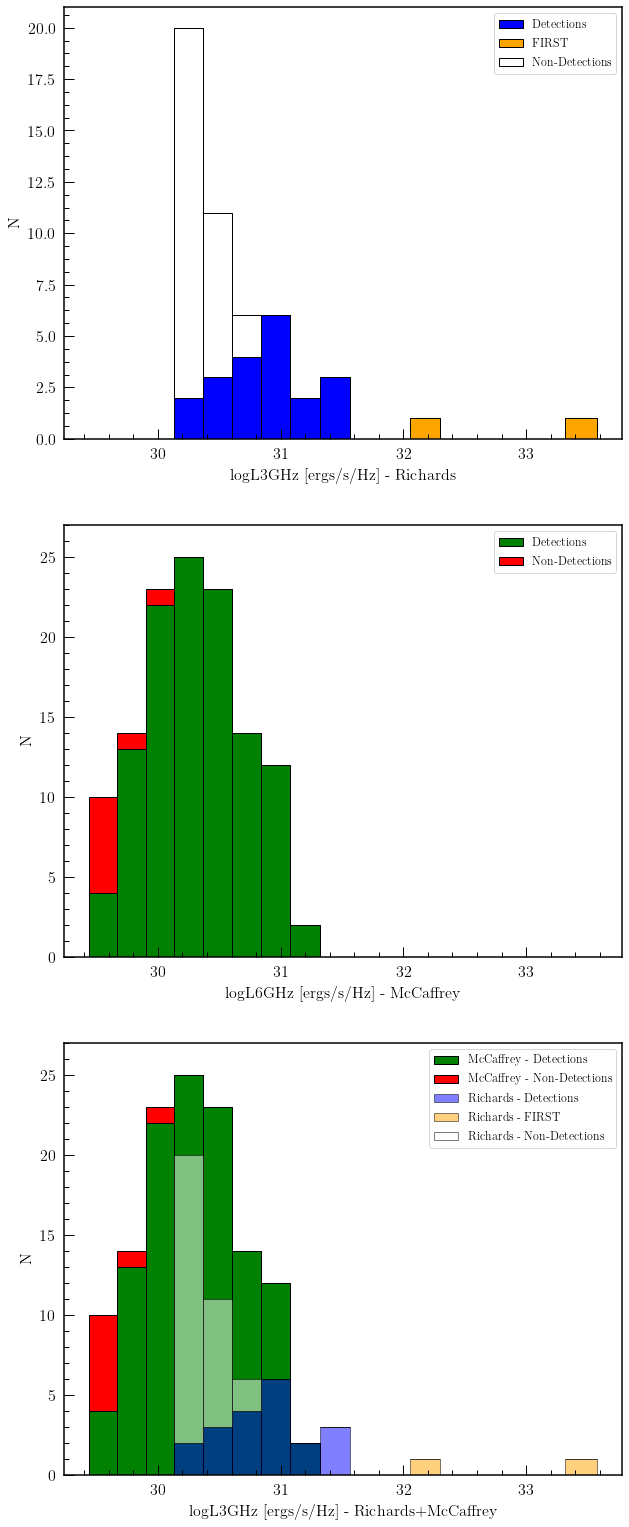

In [23]:
sf = (10**(np.median(richards_L2500)) / 10**(np.median(L2500)))
radbins = np.logspace(np.log10(min(min(richards_Lrad), min(Lrad3GHz+np.log10(sf)))), np.log10(max(max(richards_Lrad), max(Lrad3GHz+np.log10(sf)))), 18)

fig,axs = plt.subplots(3, 1, figsize=(10,27))

axs[0].hist([richards_Lrad[det==1], richards_Lrad[det==2], richards_Lrad[det==0]], color=["blue", "orange", "w"],
            edgecolor="k", histtype='barstacked', label=["Detections", "FIRST", "Non-Detections"], bins=radbins)

#axs[0].set_xscale("log")
axs[0].legend(loc="best")
axs[0].set_xlabel("logL3GHz [ergs/s/Hz] - Richards")
axs[0].set_ylabel("N")


axs[1].hist([Lrad3GHz[D==1]+np.log10(sf), Lrad3GHz[D==0]+np.log10(sf)], color=["g", "r"],
            edgecolor="k", histtype='barstacked', label=["Detections", "Non-Detections"], bins=radbins)

#axs[1].set_xscale("log")
axs[1].legend(loc="best")
axs[1].set_ylim(0,27)
axs[1].set_xlabel("logL6GHz [ergs/s/Hz] - McCaffrey")
axs[1].set_ylabel("N")



axs[2].hist([Lrad3GHz[D==1]+np.log10(sf), Lrad3GHz[D==0]+np.log10(sf)], color=["g", "r"],
            edgecolor="k", histtype='barstacked', label=["McCaffrey - Detections", "McCaffrey - Non-Detections"],
            bins=radbins)

axs[2].hist([richards_Lrad[det==1], richards_Lrad[det==2], richards_Lrad[det==0]], color=["blue", "orange", "w"],
            edgecolor="k", histtype='barstacked', bins = radbins,
            label=["Richards - Detections", "Richards - FIRST", "Richards - Non-Detections"], alpha=0.5)


axs[2].legend(loc="best")
axs[2].set_ylim(0,27)
axs[2].set_xlabel("logL3GHz [ergs/s/Hz] - Richards+McCaffrey")
axs[2].set_ylabel("N")

extent = full_extent(axs[2]).transformed(fig.dpi_scale_trans.inverted())
# Alternatively,
# extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
fig.savefig('RichardsvsMcC_luminositydistribution.pdf', bbox_inches=extent)
#axs[2].savefig("RichardsvsMcC_luminositydistribution.pdf")

Scaled McCaffrey radio luminosities for comparison:
   * According to optical luminosities relative to Richards sample
   * To 3GHz assuming a radio spectral index $\alpha=-0.7$
   
   $$\frac{L_{rad}}{4\pi D_{L}^2} = f_{int}10^{-23} \frac{(1+2)^{\alpha_{\nu}}}{(1+z)^{1+\alpha_{\nu}}}$$
   
   
Questions:
   * Correct equation  for radio luminosities? - not sure what was used in Kellerman+2016 (or whether it was some variation of equation from K&R2015 modulo K-corrections)

----

## Demographics of McC/Kimball sample

Median IF/IF_Kell = 0.9156304222093696
Fraction of sources <0.8: 0.37
Fraction of sources >1.2: 0.26


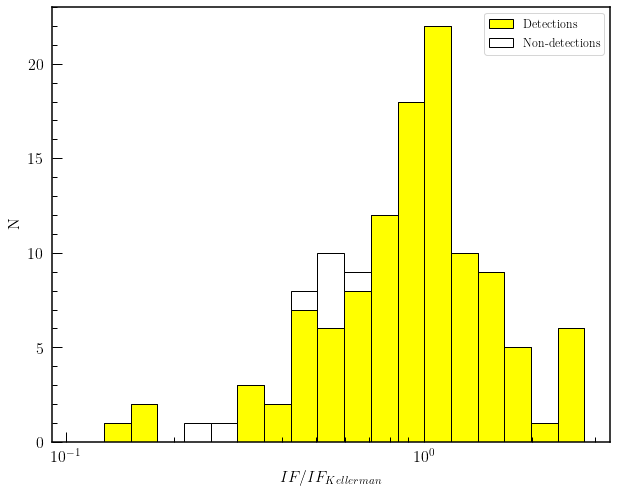

In [6]:
plt.figure(figsize=(10,8))
plt.hist([flux[D==1]/kell_intf[D==1], flux[D==0]/kell_intf[D==0]], histtype="barstacked", color=["yellow", "w"], 
         edgecolor="k", bins=np.logspace(np.log10(.1075),np.log10(2.8), 20), label=["Detections", "Non-detections"])
plt.xscale("log")
plt.xlabel("$IF/IF_{Kellerman}$")
plt.ylabel("N")
plt.legend(loc="best")
plt.ylim(0,23)

print("Median IF/IF_Kell =", np.median(flux/kell_intf))

#VLA flux measurements not extremely accurate to interpret as-is; 
#for how many does the int flux ratio differ by >±20%?

print("Fraction of sources <0.8: %.2f" % (((flux/kell_intf)<=0.8).sum()/len(flux)))
print("Fraction of sources >1.2: %.2f" % (((flux/kell_intf)>=1.2).sum()/len(flux)))

In [7]:
np.logspace(np.log10(.1075),np.log10(2.8), 20)

array([0.1075    , 0.12762084, 0.15150771, 0.1798655 , 0.21353103,
       0.25349777, 0.3009451 , 0.35727318, 0.42414421, 0.50353154,
       0.59777785, 0.70966429, 0.84249258, 1.00018243, 1.18738718,
       1.40963116, 1.67347268, 1.98669757, 2.35854896, 2.8       ])

In [8]:
len(np.linspace(1, 20, 20))

20

Text(0.5, 0, '$\\Delta$RA [arcsec]')

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


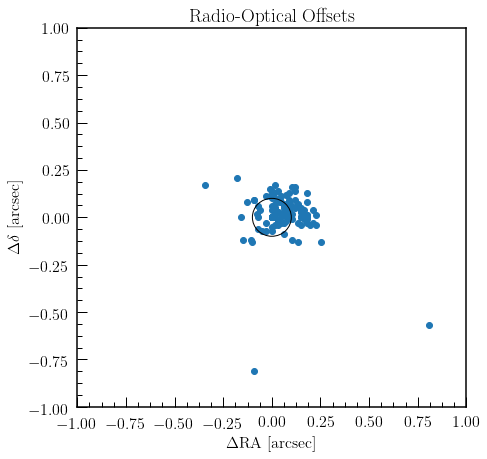

In [9]:
plt.scatter(RAoff, DECoff)

circle=plt.Circle((0, 0), 0.1, color='k', fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle)

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Radio-Optical Offsets")
plt.ylabel("$\Delta \delta$ [arcsec]")
plt.xlabel("$\Delta$RA [arcsec]")

Objects inside circle are within SDSS positional uncertainties ~ 0.1arcsec

4 objects with offsets larger than within above plot range

Text(0, 0.5, "Flux measured with 'imfit'")

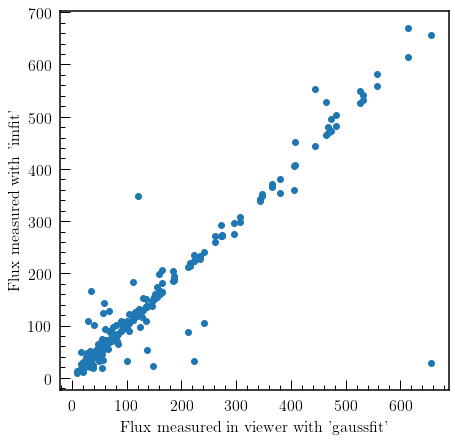

In [10]:
plt.scatter([intf_viewer, intf_viewer], [intf_viewer, core_intflux])
plt.xlabel("Flux measured in viewer with 'gaussfit'")
plt.ylabel("Flux measured with 'imfit'")

Text(0.5, 1.0, 'viewer IF vs. PF')

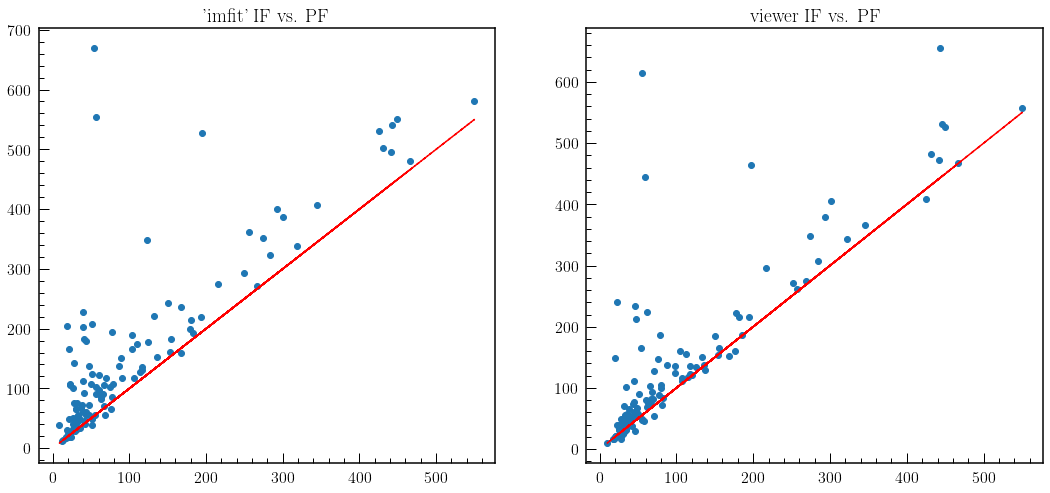

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))

axs[0].scatter(core_peakflux, flux)
axs[0].plot(core_peakflux, core_peakflux, '--r')
axs[0].set_title("'imfit' IF vs. PF")

axs[1].scatter(pf_viewer, intf_viewer)
axs[1].plot(pf_viewer, pf_viewer, '--r')
axs[1].set_title("viewer IF vs. PF")

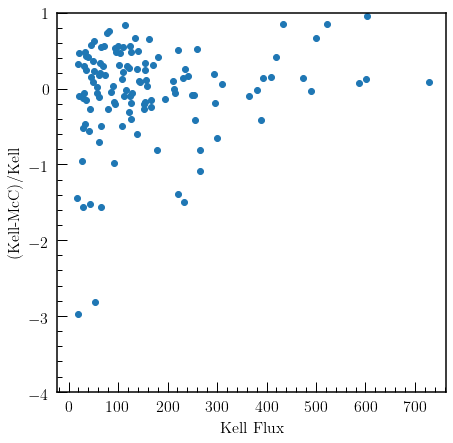

Fraction with resolved out emission (>0)    : 54.83870967741935%
Fraction without resolved out emission (<0) : 45.16129032258064%


In [12]:
resolved_emission = (kell_intf-flux) / kell_intf
resolved_out = (resolved_emission>0)

plt.scatter(kell_intf, resolved_emission)
plt.ylim(-4,1)
plt.ylabel("(Kell-McC)/Kell")
plt.xlabel("Kell Flux")
plt.show()

print("Fraction with resolved out emission (>0)    : {}%".format(resolved_out.sum()/len(resolved_out)*100))
print("Fraction without resolved out emission (<0) : {}%".format((len(resolved_out)-resolved_out.sum())/len(resolved_out)*100))

y > 0 in above graph indicates a source with McC flux < Kell flux

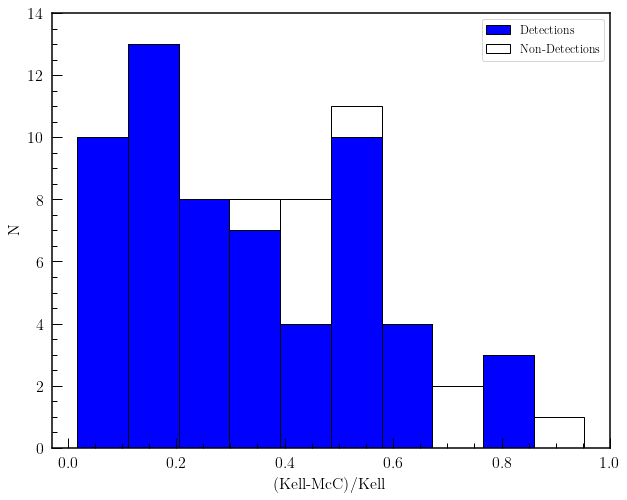

In [13]:
fig = plt.figure(figsize=(10,8))

plt.hist([resolved_emission[(D==1)&resolved_out], resolved_emission[(D==0)&resolved_out]], color=["b", "w"], edgecolor="k", histtype="barstacked",
         label=["Detections", "Non-Detections"])

plt.legend(loc="best")
plt.xlabel("(Kell-McC)/Kell")
plt.ylabel("N")
plt.ylim(0,14)
plt.show()

^ Only consider sources with McC < Kell

(-0.01, 1)

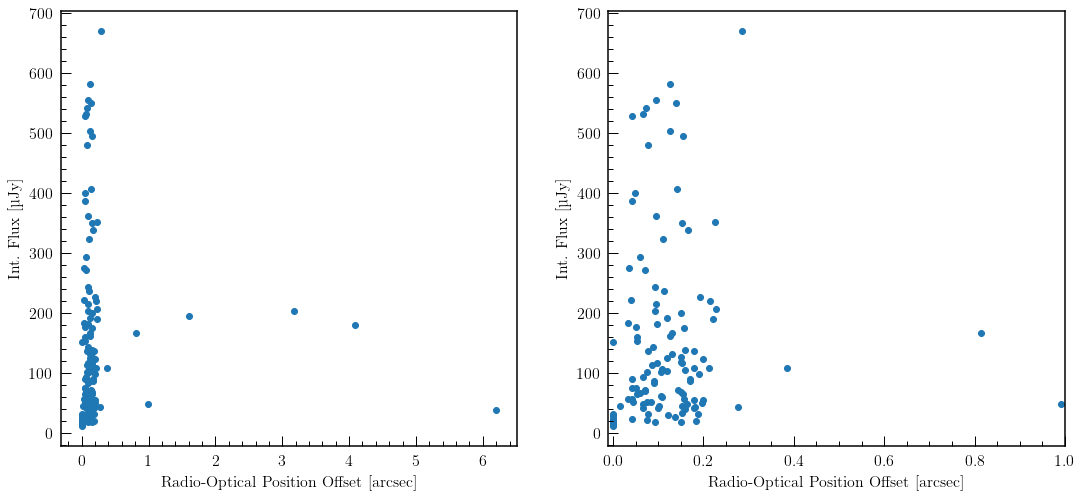

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))

axs[0].scatter(ROoff, flux)
axs[0].set_ylabel("Int. Flux [µJy]")
axs[0].set_xlabel("Radio-Optical Position Offset [arcsec]")

axs[1].scatter(ROoff, flux)
axs[1].set_ylabel("Int. Flux [µJy]")
axs[1].set_xlabel("Radio-Optical Position Offset [arcsec]")
axs[1].set_xlim(-.01,1)

Text(0.5, 0, 'Major axis size convolved with beam [marcsec]')

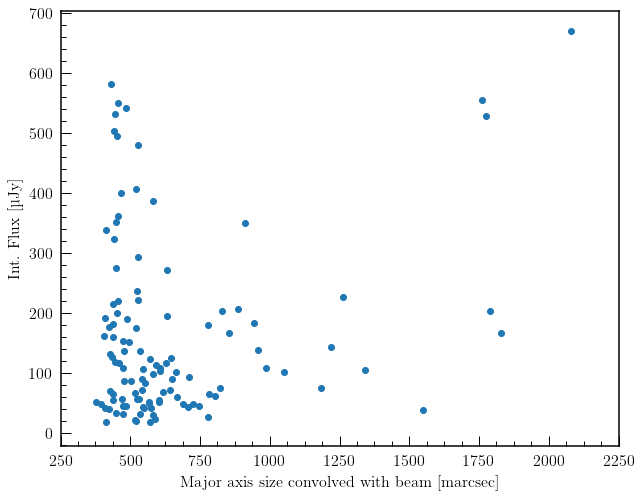

In [15]:
fig = plt.figure(figsize=(10,8))

plt.scatter(majaxis, flux)
plt.xlim(250, 2250)
plt.ylabel("Int. Flux [µJy]")
plt.xlabel("Major axis size convolved with beam [marcsec]")